In [1]:
from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
from thllib import util
import figurefirst as fifi
from scipy import signal

In [2]:
sp = 20. #sample period ms
MK_TON1 = 10/1000. #ms
MK_TON2 = 10/1000. #ms
MK_TOFF1 = 100/1000. #ms
MK_TOFF2 = 300/1000.

def make_single_kernel(times,tauon1,tauoff1):
    kx = np.copy(times)
    kon1 = lambda x:np.exp(((-1*tauon1)/(x)))
    koff1 = lambda x:np.exp((-1*x)/tauoff1)
    k1 = (kon1(kx)*koff1(kx))
    return k1/np.max(k1)

In [3]:
%matplotlib inline

In [4]:
fly = flb.NetFly(1530,rootpath='/media/imager/FlyDataD/FlyDB/')
fly.open_signals()

In [5]:
popt = [0.01636028, 0.23604393]

In [6]:
flynumbers = \
list(range(1389,1402)) #+ \

In [7]:
flylist = [flb.NetFly(fnum) for fnum in flynumbers]

In [8]:
fly = flylist[4]

In [9]:
fly.open_signals()

In [10]:
snum = 4
l = fly.block_data['left', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]
r = fly.block_data['right', 'amp', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]
x = fly.block_data['common', 'x_pos', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]

idxs = fly.block_data['common','idx', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'][snum]
times = np.arange(len(x))*0.02
sig = fly.ca_cam_left_model_fits['i1'][idxs]

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide


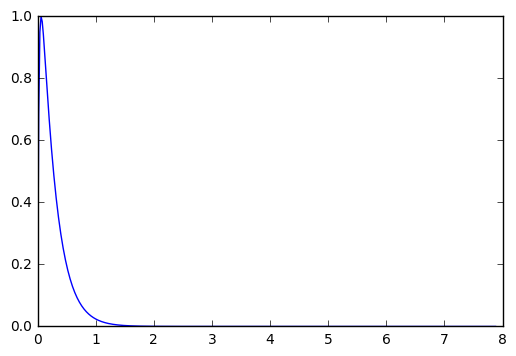

In [11]:
plt.plot(times,make_single_kernel(times,*popt))

In [100]:
test_freq = np.array(fly.wb_freq[idxs[0]:idxs[-1]])
test_ca_sig = np.array(fly.ca_cam_left_model_fits['iii3'][idxs[0]:idxs[-1]])
test_ca_time = np.array(fly.time[idxs[0]:idxs[-1]])
test_ca_time -= test_ca_time[0]

In [119]:
resample_rate = 1000. #Hz
resample_times = np.arange(test_ca_time[-1]*resample_rate)*(1/resample_rate)

In [102]:
resampled_ca,resampled_t = signal.resample(test_ca_sig,
                                           len(resample_times),
                                           test_ca_time,window = 'hamming')

resampled_freq,resampled_t = signal.resample(test_freq,
                                           len(resample_times),
                                           test_ca_time,window = 'hamming')

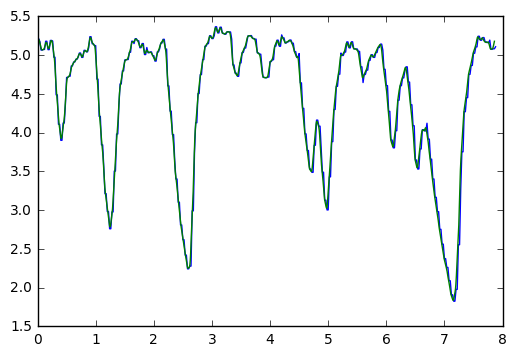

In [103]:
plt.plot(times,fly.ca_cam_left_model_fits['iii3'][idxs])
plt.plot(resample_times,resampled_ca)
#plt.plot(wiener_deconvolution(fly.ca_cam_left_model_fits['i1'][idxs]*10,kernel,1.5))
#plt.plot(wiener_deconvolution(fly.ca_cam_left_model_fits['i1'][idxs]*10,kernel*0.1,1.5))

In [104]:
#flight_epoch_idx = np.squeeze(np.argwhere(np.squeeze(resampled_freq)>50))
impulse_idxs = list()
#spike_idx = flight_epoch_idx[0]
spike_idx = 1
spike_time = resample_times[spike_idx]
#while(spike_idx < flight_epoch_idx[-1]):
while(spike_time<resample_times[-1]):
    spike_idx = np.argwhere(resample_times<spike_time)[-1][0]
    #print spike_idx
    impulse_idxs.append(spike_idx)
    isi = 1./resampled_freq[spike_idx]
    spike_time += isi

In [124]:
impulse_idxs = np.array(impulse_idxs)

In [105]:
resampled_ca -= np.min(resampled_ca)

In [159]:
kernel_gain = 0.05

In [179]:
kernel = make_single_kernel(resample_times,*popt)

def forward_optimize(resampled_ca,resample_times,
                     kernel,
                     objective_window_s = 2,kernel_gain = 0.05):
    kernel = kernel*kernel_gain
    recon = np.zeros_like(resample_times)
    impulses = np.zeros_like(resample_times)
    objective_window_idx = objective_window_s*resample_rate
    max_idx = len(resample_times)
    end_first_loop = max_idx - objective_window_idx
    last_imp = np.argwhere(impulse_idxs < end_first_loop)[-1][0]
    for imp_idx,nxt_idx in zip(impulse_idxs[:last_imp],impulse_idxs[1:last_imp+1]):
        if (imp_idx + objective_window_idx) > max_idx:
            objective_window = max_idx - imp_idx
        imp_window = impulses[imp_idx:imp_idx+2000]
        n1 = np.linalg.norm(recon[imp_idx:nxt_idx]-resampled_ca[imp_idx:nxt_idx])
        recon[imp_idx:imp_idx+2000] += kernel[:2000]
        n2 = np.linalg.norm(recon[imp_idx:nxt_idx] - resampled_ca[imp_idx:nxt_idx])
        if n2>n1:
            recon[imp_idx:imp_idx+2000] -= kernel[:2000]
        else:
            impulses[imp_idx] = 1
    return recon,impulses

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide


In [183]:
errors = list()
for kg in np.linspace(0,2,100):
    recon,impulses = forward_optimize(resampled_ca,resample_times,kernel,kernel_gain = kg)
    errors.append(np.linalg.norm(resampled_ca[1000:5000]-recon[1000:5000]))

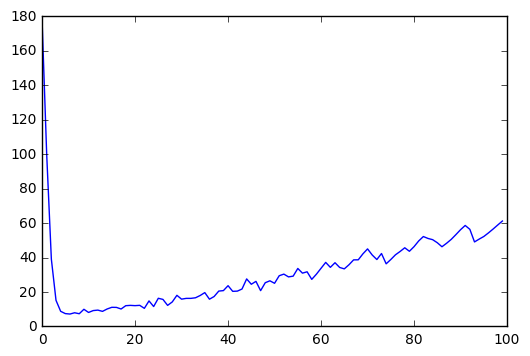

In [184]:
plt.plot(errors)

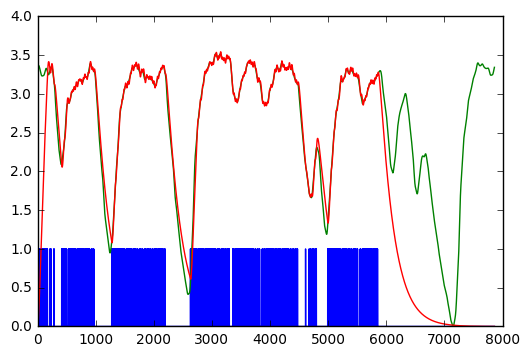

In [181]:
plt.plot(impulses)
plt.plot(resampled_ca)
plt.plot(recon)
#plt.gca().set_xbound(4000,6000)

In [82]:
np.mean(np.diff(impulse_idxs))

9.2338425381903644

NameError: name 'impulse_idxs' is not defined

In [14]:
def wiener_deconvolution(signal, kernel, snr):
    "lambd is the SNR"
    from scipy import fft,ifft
    kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length
    H = fft(kernel)
    deconvolved = np.real(ifft(fft(signal)*np.conj(H)/(H*np.conj(H) + snr**2)))
    return deconvolved

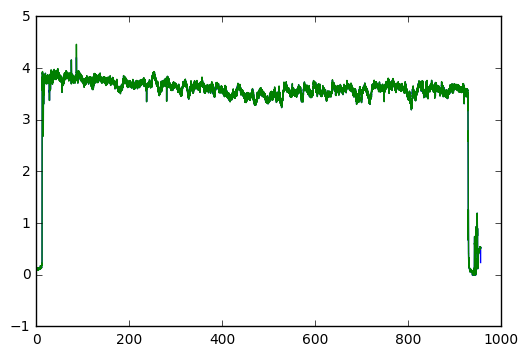

In [658]:
plt.plot(resample_times,resampled_ca)
plt.plot(test_ca_time,fly.ca_cam_left_model_fits['b1'])

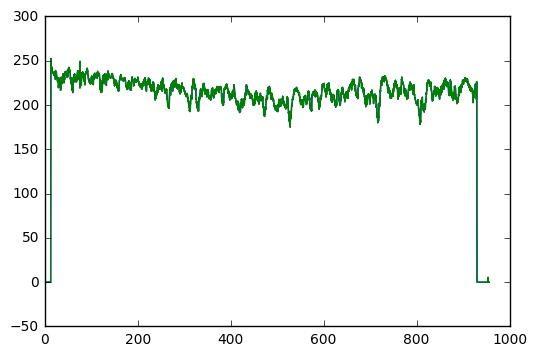

In [660]:
plt.plot(resample_times,resampled_freq)
plt.plot(test_ca_time,test_freq)

In [672]:
spike_time = 0.01
np.argwhere(resample_times<0.01)[-1][0]

199

In [ ]:
kernel = make_single_kernel(resample_times,*popt)*0.1

In [ ]:
decon = np.real(np.fft.ifft(np.fft.fft(resampled_ca)/np.fft.fft(kernel)))
decon = wiener_deconvolution(resampled_ca,kernel,1.1)

In [ ]:
impulses = np.zeros_like(resample_times)
impulses[impulse_idxs] = 1#(decon>0.002)[impulse_idxs]
plt.subplot(2,1,1)
plt.plot(decon)
plt.subplot(2,1,2)
plt.plot(impulses)
#plt.plot(resampled_ca)
#plt.plot(kernel)

In [697]:
np.shape(resampled_freq)

(19120000, 1)

array([  258654,   258655,   258656, ..., 18589398, 18589399, 18589400])

In [679]:
kernel = make_single_kernel(resample_times,*popt)*0.1

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide


In [680]:
resampled_ca-= np.min(resampled_ca)

In [688]:
spike_idx

258654

In [690]:
impulse_idxs

[]

In [225]:
#fk = np.fft.fft(kernel[:40000])

In [14]:
recon = np.zeros_like(resample_times)
impulses = np.zeros_like(resample_times)
for imp_idx in impulse_idxs[:-600]:
    imp_window = impulses[imp_idx:imp_idx+50000]
    #ca_window = resampled_ca[imp_idx:imp_idx+40000]
    n1 = np.sum(np.abs(recon[imp_idx:imp_idx+50000]-resampled_ca[imp_idx:imp_idx+50000]))
    #c1 = np.fft.ifft(np.fft.fft(imp_window)*fk)
    #print imp_idx+40000
    recon[imp_idx:imp_idx+50000] += kernel[:50000]
    n2 = np.sum(np.abs(np.abs(recon[imp_idx:imp_idx+50000] - resampled_ca[imp_idx:imp_idx+50000])))
    #c2 = np.fft.ifft(np.fft.fft(imp_window)*fk)
    if n2>n1:
        recon[imp_idx:imp_idx+50000] -= kernel[:50000]
    else:
        impulses[imp_idx] = 1

NameError: name 'resample_times' is not defined

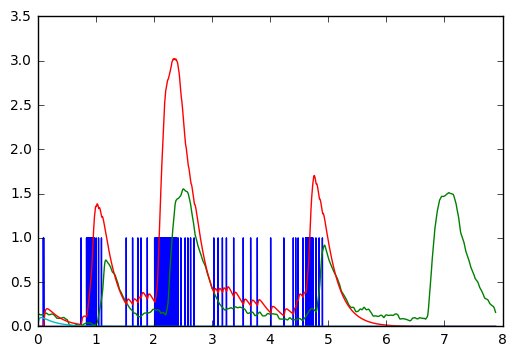

In [468]:
plt.plot(resample_times,impulses)
plt.plot(resample_times, resampled_ca)
plt.plot(resample_times,recon)
plt.plot(resample_times,kernel)

In [522]:
kernel = make_single_kernel(resample_times,*popt)*0.1
recon = np.zeros_like(resample_times)
impulses = np.zeros_like(resample_times)
for imp_idx in impulse_idxs[:-600][::-1]:
    imp_window = impulses[imp_idx:imp_idx+50000]
    n1 = np.linalg.norm(recon[imp_idx:imp_idx+50000] -
                        resampled_ca[imp_idx:imp_idx+50000])
    recon[imp_idx:imp_idx+50000] += kernel[:50000]
    n2 = np.linalg.norm(recon[imp_idx:imp_idx+50000] - 
                        resampled_ca[imp_idx:imp_idx+50000])
    if n2>n1:
        recon[imp_idx:imp_idx+50000] -= kernel[:50000]
    else:
        impulses[imp_idx] = 1
        
#for imp_idx in impulse_idxs[:-600]:
#    imp_window = impulses[imp_idx:imp_idx+50000]
#    n1 = np.linalg.norm(recon[imp_idx:imp_idx+50000] -
#                        resampled_ca[imp_idx:imp_idx+50000])
#    recon[imp_idx:imp_idx+50000] -= kernel[:50000]
#    n2 = np.linalg.norm(recon[imp_idx:imp_idx+50000] - 
#                        resampled_ca[imp_idx:imp_idx+50000])
#    if n2>n1:
#        recon[imp_idx:imp_idx+50000] += kernel[:50000]
#    else:
#        impulses[imp_idx] = 0

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide


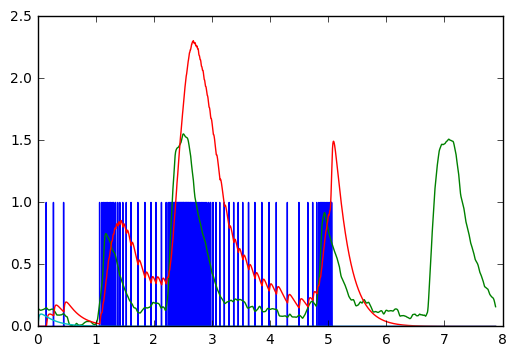

In [523]:
plt.plot(resample_times,impulses)
plt.plot(resample_times, resampled_ca)
plt.plot(resample_times,recon)
plt.plot(resample_times,kernel)

In [251]:
impulses.dtype = bool

In [264]:
#?np.random.choice

In [362]:
rand_idx = np.random.choice(impulse_idxs,size = len(impulse_idxs)/2,replace = False)

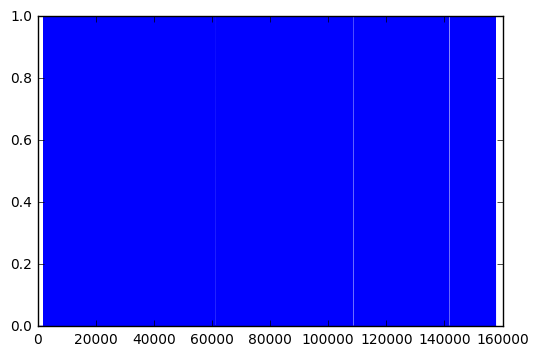

In [371]:
impulses[rand_idx] = (impulses[rand_idx]*-1.)+1.
plt.plot(impulses)

In [372]:
recon = np.zeros_like(resample_times)
impulses = np.zeros_like(resample_times)

In [390]:
def check_flip(rand_idx,current_error):
    impulses[rand_idx] = (impulses[rand_idx]*-1)+1
    conv = signal.fftconvolve(impulses,kernel,mode = 'full')
    conv = conv[0:len(impulses)]
    if np.linalg.norm(resampled_ca-conv) > current_error:
        impulses[rand_idx] = (impulses[rand_idx]*-1)+1
        return current_error
    else:  
        return np.linalg.norm(resampled_ca-conv)

In [391]:
a_sched = len(impulse_idxs) - np.arange(len(impulse_idxs))

In [412]:
len(impulse_idxs)

1685

In [430]:
a_sched

array([1685, 1685, 1685, ...,   49,   49,   49])

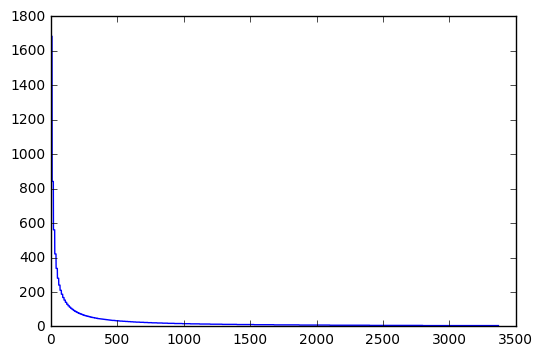

In [433]:
a_sched = (len(impulse_idxs))/(0.1*np.arange(len(impulse_idxs)*2)+1).astype(int)
plt.plot(a_sched)

In [446]:
a_sched

array([1685, 1685, 1685, ...,    5,    5,    5])

In [457]:
err_list = []
current_error = 100000
new_error = current_error-1
for choice_size in a_sched:
    print choice_size
    while(True):
        current_error = new_error
        err_list.append(current_error)
        rand_idx = np.random.choice(impulse_idxs,size = choice_size,replace = False)
        new_error = check_flip(rand_idx,current_error)
        if (new_error>=current_error):
            break

1685
1685
1685
1685
1685
1685
1685
1685
1685
1685
842
842
842
842
842
842
842
842
842
842
561
561
561
561
561
561
561
561
561
561
421
421
421
421
421
421
421
421
421
421
337
337
337
337
337
337
337
337
337
337
280
280
280
280
280
280
280
280
280
280
240
240
240
240
240
240
240
240
240
240
210
210
210
210
210
210
210
210
210
210
187
187
187
187
187
187
187
187
187
187
168
168
168
168
168
168
168
168
168
168
153
153
153
153
153
153
153
153
153
153
140
140
140
140
140
140
140
140
140
140
129
129
129
129
129
129
129
129
129
129
120
120
120
120
120
120
120
120
120
120
112
112
112
112
112
112
112
112
112
112
105
105
105
105
105
105
105
105
105
105
99
99
99
99
99
99
99
99
99
99
93
93
93
93
93
93
93
93
93
93
88
88
88
88
88
88
88
88
88
88
84
84
84
84
84
84
84
84
84
84
80
80
80
80
80
80
80
80
80
80
76
76
76
76
76
76
76
76
76
76
73
73
73
73
73
73
73
73
73
73
70
70
70
70
70
70
70
70
70
70
67
67
67
67
67
67
67
67
67
67
64
64
64
64
64
64
64
64
64
64
62
62
62
62
62
62
62
62
62
62
60
60
60
60
60
60
60

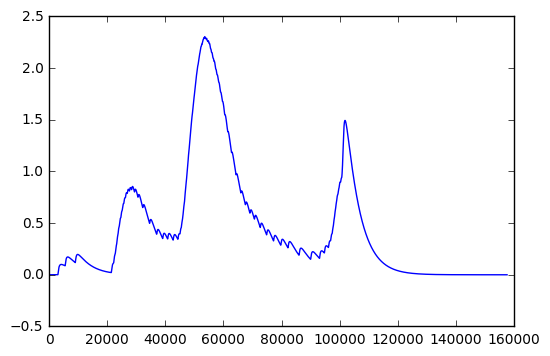

In [524]:
conv = signal.fftconvolve(impulses,kernel,mode = 'full')
conv = conv[0:len(impulses)]
#plt.plot(err_list[1:])
plt.plot(conv)

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide


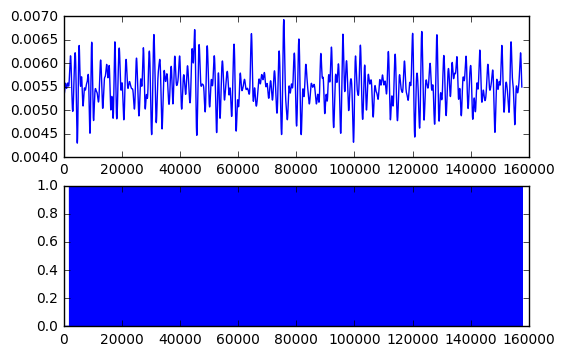

In [646]:
kernel = make_single_kernel(resample_times,*popt)*0.1

decon = np.real(np.fft.ifft(np.fft.fft(resampled_ca)/np.fft.fft(kernel)))
decon = wiener_deconvolution(resampled_ca,kernel,1.1)

impulses = np.zeros_like(resample_times)
impulses[impulse_idxs] = (decon>0.0045)[impulse_idxs]
plt.subplot(2,1,1)
plt.plot(decon)
plt.subplot(2,1,2)
plt.plot(impulses)
#plt.plot(resampled_ca)
#plt.plot(kernel)

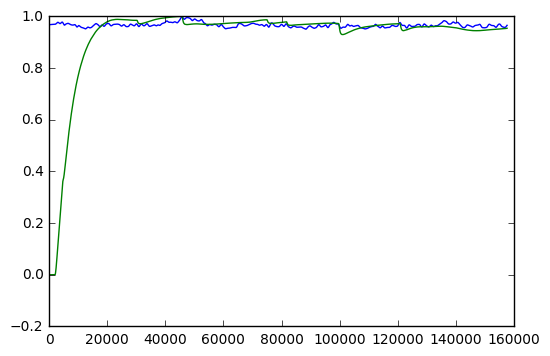

In [647]:
plt.plot(resampled_ca/np.max(resampled_ca))
recons = signal.fftconvolve(impulses,kernel)
recons = recons[:len(resampled_ca)]
plt.plot(recons/np.max(recons))

In [629]:
popt

[0.01636028, 0.23604393]